In this notebook I will trial a working concept of the core functionality.

Main design:
- Indexed bam file is read by multiple workers in paralllel
- Each worker fetches a region and applies a user-specified function over the region.
- Regions can be specified manually by user, or defined automatically according to different schemes. First scheme to implement is `byfeature` which bins genome into N non-overlapping regions that each contain features of coordinates `(start, end)` such that each feature is contained in only one region.

In [1]:
import pysam
import mppysam.read_bam as rb
import mppysam.regions as rg
import timeit
import matplotlib.pyplot as plt

In [2]:
bamfilepath = "../data/SLX-18505_N701_A03_r2.umiAppend.Aligned.out.featureCounts.sorted.bam"

In [3]:
samfile = pysam.AlignmentFile(bamfilepath, "rb")

In [16]:
print(
    "contigs", samfile.nreferences,
    "- mapped reads", sum(mapped for _, mapped, unmapped, total in samfile.get_index_statistics()),
    "- unmapped reads", sum(unmapped for _, mapped, unmapped, total in samfile.get_index_statistics())
)

contigs 352 - mapped reads 1773360 - unmapped reads 0


In [5]:
samfile.references[0:9]

('1.human',
 '10.human',
 '11.human',
 '12.human',
 '13.human',
 '14.human',
 '15.human',
 '16.human',
 '17.human')

In [78]:
samfile.count('1.human', 0, 1e8)

121946

In [2]:
def benchmark_read_bam(bampath=None, **kwargs):
    bampath = bamfilepath if bampath is None else bampath
    rb.read_bam(bampath, **kwargs)

def benchmark_effect_chunks(chunks_args, bampath=None, number=3,
                            **kwargs):
    timings = [
        timeit.timeit(
            lambda: benchmark_read_bam(
                bampath,
                processes=1,
                regions=[rg.Region("1.human", 0, 1e8)], #120k reads
                chunks=chunks,
                **kwargs
            ),
            number=number
        ) / number
        for chunks in chunks_args
    ]
    return chunks_args, timings

def benchmark_effect_processes(processes_args, bampath=None, number=3,
                               **kwargs):
    timings = [
        timeit.timeit(
            lambda: benchmark_read_bam(
                bampath,
                processes=processes,
                chunks=processes,
                **kwargs
            ),
            number=number
        ) / number
        for processes in processes_args
    ]
    return processes_args, timings

Text(0.5, 1.0, 'Effect of chunking on performance.\n 100Mb genomic region - 120k reads - 1 process.')

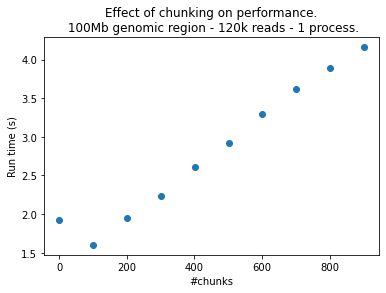

In [80]:
plt.scatter(*benchmark_effect_chunks(chunks_args = range(1, 1000, 100)))
plt.xlabel("#chunks")
plt.ylabel("Run time (s)")
plt.title("Effect of chunking on performance.\n 100Mb genomic region - 120k reads - 1 process.")

Text(0.5, 1.0, 'Effect of processes on performance.\n Whole genome.')

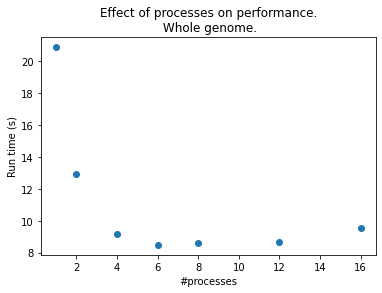

In [74]:
plt.scatter(
    *benchmark_effect_processes(processes_args = (1, 2, 4, 6, 8, 12, 16)))
plt.xlabel("#processes")
plt.ylabel("Run time (s)")
plt.title("Effect of processes on performance.\n 1.7M reads.")

In [3]:
largerbampath = "/servers/bio-shares-3/chalut/jb2094/projects/190701_shu_GSE115943/map/D14_2i_C1.bam"

In [4]:
samfile = pysam.AlignmentFile(largerbampath, "rb")
print(
    "contigs", samfile.nreferences,
    "- mapped reads", sum(mapped for _, mapped, unmapped, total in samfile.get_index_statistics()),
    "- unmapped reads", sum(unmapped for _, mapped, unmapped, total in samfile.get_index_statistics())
)

contigs 66 - mapped reads 100502822 - unmapped reads 0


Text(0.5, 1.0, 'Effect of processes on performance.\n 100M reads - get_read_name()')

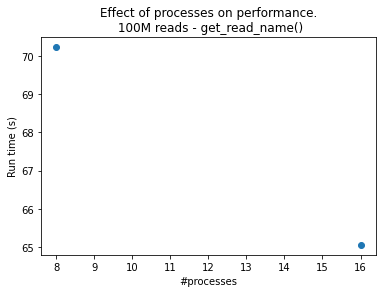

In [8]:
def get_read_name(read):
    return read.query_name

plt.scatter(
    *benchmark_effect_processes(
        processes_args=(8, 16),
        bampath=largerbampath,
        number=1,
        row_func=get_read_name
    )
)
plt.xlabel("#processes")
plt.ylabel("Run time (s)")
plt.title("Effect of processes on performance.\n 100M reads - get_read_name()")